*Import libraries*

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

import os, os.path

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions

from tensorflow.keras.preprocessing.image import load_img

In [6]:
from collections import defaultdict
from hashlib import md5
from pathlib import Path

import PIL
from PIL import Image

import matplotlib.image as mpimg

# Kitchenware Classification

Competition Link: https://www.kaggle.com/competitions/kitchenware-classification/

Competition Objective: Through machine learning, we want to identify if an image is a spoon, fork, plate, cup, glass, or knife:

Notebook Contents:
* Dataset Preparation
* Model Preparation and Training
    - How to work with images
    - Use Pre-trained Convoluitional Neural Network with ImageNet model
    - Creation of Base Model with ImageNet's convolutional layers
    - Creation of Final Model using the Base Model and addition of dense layers
    - Training the Model
* Tuning the Performance of the model
    - adjust the learning rate
    - Checkpointing
    - Adding more layers
    - Regularization and dropout
    - Data augmentation
    - Training a larger model
* Testing the model
    - test on 1 image
    - test on the whole test images
* Saving the model

## Dataset Preparation

1. Download the dataset from the competition link.
2. Create a folder 'dataset'
3. Put the data downloaded inside the 'dataset' directory.

Here are the expected directory structure:

<img style="float: left" src="./docu/images/dataset_dir.png" alt="Alternative text" />

In [21]:
# Setting the dataset directories
dirs = {}

dirs['dataset_dir'] = './dataset'
dirs['raw_img_dir'] = './dataset/images'

Check train.csv and test.csv

In [22]:
#Check train.csv and test.csv
train_info = pd.read_csv(dirs['dataset_dir'] + '/train.csv', dtype = 'string')
test_info = pd.read_csv(dirs['dataset_dir'] + '/test.csv', dtype = 'string')

In [23]:
train_info.head()

,Id,label
0,0560,glass
1,4675,cup
2,0875,glass
3,4436,spoon
4,8265,plate


In [24]:
test_info.head()

,Id
0,0678
1,3962
2,9271
3,5133
4,8842


Details:
* train.csv - contains the images to be used for training the model. It includes the label it belongs to
* test.csv - contains the images to be used for testing the images which will be used for submission in the competition

Then, we will use the dataprep.py file to:
* remove duplicate images
* sort the images into train and test
* further separate the train folder to train and validation sets
    * random shuffling with seed = 42

In [18]:
import dataprep as dp

In [8]:
dp.call_class('./dataset')

File 7196.jpg is a duplicate image. File is removed
File 6833.jpg is a duplicate image. File is removed
File 4234.jpg is a duplicate image. File is removed
File 7103.jpg is a duplicate image. File is removed
File 4162.jpg is a duplicate image. File is removed
File 6624.jpg is a duplicate image. File is removed
Successful data preparation


Set the project directory directories

In [25]:
# Add the sorted train, validation, and test data
dirs['sorted_img_train'] = './dataset/sorted_images_train'
dirs['sorted_img_val'] = './dataset/sorted_images_val'
dirs['img_dir_test'] = './dataset/sorted_test'

In [26]:
## Check the count of the sorted train, validation and test data
subd_train={}
for fn in Path(dirs['sorted_img_train'] ).glob('**/*'):
    if fn.is_file():
        key=str(fn.parent)
        subd_train[key] = subd_train.get(key, 0)+1
        
subd_val={}
for fn in Path(dirs['sorted_img_val'] ).glob('**/*'):
    if fn.is_file():
        key=str(fn.parent)
        subd_val[key]=subd_val.get(key, 0)+1


subd_test={}
for fn in Path(dirs['img_dir_test'] ).glob('**/*'):
    if fn.is_file():
        key=str(fn.parent)
        subd_test[key]=subd_test.get(key, 0)+1

In [27]:
subd_train

{'dataset/sorted_images_train/cup': 907,
 'dataset/sorted_images_train/fork': 444,
 'dataset/sorted_images_train/plate': 982,
 'dataset/sorted_images_train/glass': 594,
 'dataset/sorted_images_train/spoon': 791,
 'dataset/sorted_images_train/knife': 727}

In [28]:
subd_val

{'dataset/sorted_images_val/cup': 227,
 'dataset/sorted_images_val/fork': 111,
 'dataset/sorted_images_val/plate': 245,
 'dataset/sorted_images_val/glass': 148,
 'dataset/sorted_images_val/spoon': 198,
 'dataset/sorted_images_val/knife': 182}

In [29]:
subd_test

{'dataset/sorted_test': 3805}

In [30]:
train_count = sum(subd_train.values())
val_count = sum(subd_val.values())
test_count = sum(subd_test.values())

In [31]:
total_files = train_count + val_count + test_count
total_files

9361

## Model Preparation and Training

### How to work with images

In [50]:
dirs

{'dataset_dir': './dataset',
 'raw_img_dir': './dataset/images',
 'sorted_img_train': './dataset/sorted_images_train',
 'sorted_img_val': './dataset/sorted_images_val',
 'img_dir_test': './dataset/sorted_test'}

In [39]:
filepath = './dataset/sorted_images_train/cup/0003.jpg'

# Path to the folder containing the subdirectories
folder_path = dirs['sorted_img_train']

sample_img = {}

# Loop through each subdirectory in the folder
for subdir in os.listdir(folder_path):
    
    # Construct the path to the subdirectory
    subdir_path = os.path.join(folder_path, subdir)
    label = os.path.basename(subdir_path)
    
    # Check if the path is a directory (i.e. a subdirectory)
    if os.path.isdir(subdir_path):
        
        # Get the first file in the subdirectory
        file_path = os.path.join(subdir_path, os.listdir(subdir_path)[0])
        
        # Open the image using the PIL library
        sample_img[label] = file_path

In [40]:
print(sample_img)

{'cup': './dataset/sorted_images_train/cup/3632.jpg', 'fork': './dataset/sorted_images_train/fork/6193.jpg', 'plate': './dataset/sorted_images_train/plate/6461.jpg', 'glass': './dataset/sorted_images_train/glass/4103.jpg', 'spoon': './dataset/sorted_images_train/spoon/5982.jpg', 'knife': './dataset/sorted_images_train/knife/2634.jpg'}


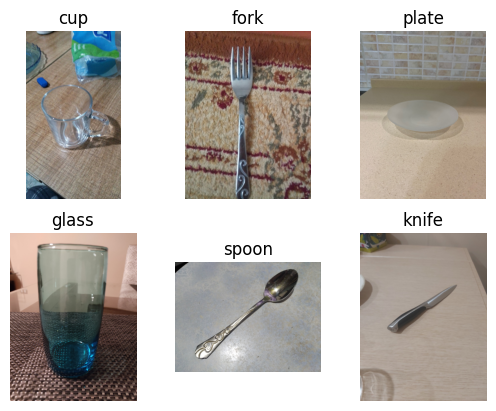

In [42]:
# Checking the sample images from each labels/classes

# Create a figure and subplot with 2 columns
fig, axs = plt.subplots(nrows = 2, ncols=3)

row_counter = 1
# Loop through each item in the dictionary
for i, (label, image_path) in enumerate(sample_img.items()):
    # Load the image from the path
    image = mpimg.imread(image_path)
    
    if row_counter >= 4:
        # Plot the image on the subplot
        axs[1, i % 3].imshow(image)
        # Set the title of the subplot to the label
        axs[1, i % 3].set_title(label)
        axs[1, i % 3].axis('off')
    else:
        # Plot the image on the subplot
        axs[0, i % 3].imshow(image)
        # Set the title of the subplot to the label
        axs[0, i % 3].set_title(label)
        axs[0, i % 3].axis('off')
    
    row_counter = row_counter+1
# Show the plot
plt.axis('off')
plt.show()

### Use Pre-trained Convoluitional Neural Network with ImageNet model
In this project, we will use Convolutional Neural Network or CNN

In [51]:
model = Xception(weights='imagenet', input_shape=(299, 299, 3))

In [52]:
filepath = './dataset/sorted_images_train/cup/3632.jpg'
img = load_img(filepath, target_size=(299, 299))

x = np.array(img)

# Batch, check notes below
X = np.array([x])

X = preprocess_input(X)

pred = model.predict(X)
decode_predictions(pred)

1/1 [==============================] - 1s 534ms/step


[[('n03733805', 'measuring_cup', 0.24426126),
  ('n04560804', 'water_jug', 0.07422784),
  ('n07930864', 'cup', 0.07335802),
  ('n07932039', 'eggnog', 0.060130972),
  ('n03950228', 'pitcher', 0.034916375)]]

Based on the prediction of the pre-trained model, we can see that the model's best prediction is that it is a measuring cup

### Creation of Base Model with ImageNet's convolutional layers
We just use the convolution layers of the ImageNet model. We will exclude the dense layers

In [54]:
dirs

{'dataset_dir': './dataset',
 'raw_img_dir': './dataset/images',
 'sorted_img_train': './dataset/sorted_images_train',
 'sorted_img_val': './dataset/sorted_images_val',
 'img_dir_test': './dataset/sorted_test'}

In [55]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_ds = train_gen.flow_from_directory(dirs['sorted_img_train'], 
                                         target_size=(150, 150), 
                                         batch_size=32, 
                                         class_mode='categorical')

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_ds = val_gen.flow_from_directory(dirs['sorted_img_val'], 
                                     target_size=(150, 150), 
                                     batch_size=32, 
                                     shuffle=False)

Found 4445 images belonging to 6 classes.
Found 1111 images belonging to 6 classes.


In [56]:
train_ds.class_indices

{'cup': 0, 'fork': 1, 'glass': 2, 'knife': 3, 'plate': 4, 'spoon': 5}

In [57]:
val_ds.class_indices

{'cup': 0, 'fork': 1, 'glass': 2, 'knife': 3, 'plate': 4, 'spoon': 5}

In [58]:
# Include_top set to False is used in order to use the convolutional layers but not the dense layers of ImageNet model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

base_model.trainable = False

### Creation of Final Model using the Base Model and addition of dense layers

In [59]:
inputs = keras.Input(shape=(150, 150, 3))

base = base_model(inputs, training=False)

vectors = keras.layers.GlobalAveragePooling2D()(base)

outputs = keras.layers.Dense(6)(vectors)

model = keras.Model(inputs, outputs)

### Training the Model

In [60]:
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

loss = keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [61]:
history = model.fit(train_ds, epochs=20, validation_data=val_ds)

Epoch 1/20
139/139 [==============================] - 81s 567ms/step - loss: 0.7254 - accuracy: 0.8279 - val_loss: 0.7225 - val_accuracy: 0.8605
Epoch 2/20
139/139 [==============================] - 76s 547ms/step - loss: 0.3871 - accuracy: 0.9021 - val_loss: 0.7260 - val_accuracy: 0.8452
Epoch 3/20
139/139 [==============================] - 80s 574ms/step - loss: 0.2352 - accuracy: 0.9350 - val_loss: 0.5724 - val_accuracy: 0.8821
Epoch 4/20
139/139 [==============================] - 79s 572ms/step - loss: 0.1680 - accuracy: 0.9485 - val_loss: 0.7849 - val_accuracy: 0.8515
Epoch 5/20
139/139 [==============================] - 78s 560ms/step - loss: 0.1198 - accuracy: 0.9620 - val_loss: 0.6690 - val_accuracy: 0.8758
Epoch 6/20
139/139 [==============================] - 79s 565ms/step - loss: 0.0814 - accuracy: 0.9730 - val_loss: 0.7687 - val_accuracy: 0.8812
Epoch 7/20
139/139 [==============================] - 78s 563ms/step - loss: 0.0681 - accuracy: 0.9780 - val_loss: 0.6854 - val_ac

Based on the result, we can see that the maximum accuracy with the validation data is around 88%

## Tuning the Performance of the model

### Adjusting the learning rate

In [62]:
def make_model(learning_rate=0.01):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(6)(vectors)
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [34]:
scores = {}

for lr in [0.0001, 0.001, 0.01, 0.1]:

    # make_model() is a custom function that creates all of the code we've seen in previous sections, except for model.fit()
    model = make_model(learning_rate=lr)

    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[lr] = history.history

Epoch 1/10
139/139 [==============================] - 81s 572ms/step - loss: 1.1602 - accuracy: 0.6009 - val_loss: 0.7334 - val_accuracy: 0.8083
Epoch 2/10
139/139 [==============================] - 80s 572ms/step - loss: 0.6242 - accuracy: 0.8174 - val_loss: 0.5250 - val_accuracy: 0.8452
Epoch 3/10
139/139 [==============================] - 80s 575ms/step - loss: 0.4872 - accuracy: 0.8496 - val_loss: 0.4495 - val_accuracy: 0.8605
Epoch 4/10
139/139 [==============================] - 79s 569ms/step - loss: 0.4225 - accuracy: 0.8662 - val_loss: 0.4060 - val_accuracy: 0.8722
Epoch 5/10
139/139 [==============================] - 81s 585ms/step - loss: 0.3829 - accuracy: 0.8770 - val_loss: 0.3785 - val_accuracy: 0.8821
Epoch 6/10
139/139 [==============================] - 80s 572ms/step - loss: 0.3542 - accuracy: 0.8831 - val_loss: 0.3618 - val_accuracy: 0.8866
Epoch 7/10
139/139 [==============================] - 79s 566ms/step - loss: 0.3317 - accuracy: 0.8894 - val_loss: 0.3475 - val_ac

In [33]:
for lr, hist in scores.items():
    #plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))

plt.xticks(np.arange(10))
plt.legend()

NameError: name 'scores' is not defined

Check on 0.0001 and 0.001 only

In [37]:
keys = [0.0001,0.001]
scores_interest = {x:scores[x] for x in keys}

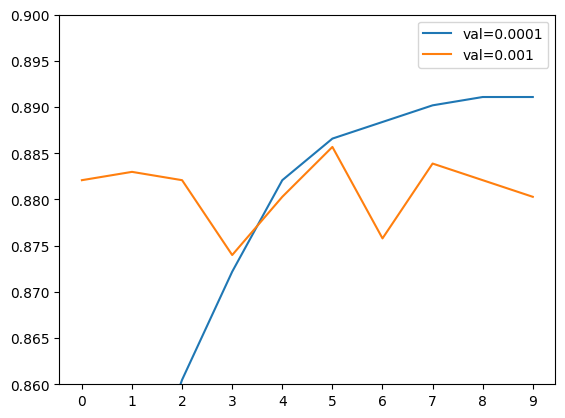

In [40]:
for lr, hist in scores_interest.items():
    #plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))

plt.ylim(0.86,0.9)
plt.xticks(np.arange(10))
plt.legend()

Based on the result, we will use `0.001` for the learning rate:
* At Epoch 0, it already has high accuracy
* Even 0.0001 has higher accuracy, it's score is not that important for us right now since the difference in accuracy is outweight by speed in training

In [63]:
learning_rate = 0.001

### Checkpointing
In order to capture the best score through each epochs, we will have checkpointing

In [41]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [44]:
learning_rate = 0.001

model = make_model(learning_rate=learning_rate)

history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[checkpoint]
)

Epoch 1/10
139/139 [==============================] - 79s 556ms/step - loss: 0.5092 - accuracy: 0.8240 - val_loss: 0.3384 - val_accuracy: 0.8731
Epoch 2/10
139/139 [==============================] - 77s 557ms/step - loss: 0.2774 - accuracy: 0.9031 - val_loss: 0.3172 - val_accuracy: 0.8785
Epoch 3/10
139/139 [==============================] - 77s 556ms/step - loss: 0.2232 - accuracy: 0.9218 - val_loss: 0.3071 - val_accuracy: 0.8848
Epoch 4/10
139/139 [==============================] - 77s 555ms/step - loss: 0.1884 - accuracy: 0.9371 - val_loss: 0.3048 - val_accuracy: 0.8821
Epoch 5/10
139/139 [==============================] - 78s 560ms/step - loss: 0.1607 - accuracy: 0.9501 - val_loss: 0.3025 - val_accuracy: 0.8893
Epoch 6/10
139/139 [==============================] - 77s 553ms/step - loss: 0.1405 - accuracy: 0.9550 - val_loss: 0.3069 - val_accuracy: 0.8812
Epoch 7/10
139/139 [==============================] - 77s 556ms/step - loss: 0.1235 - accuracy: 0.9618 - val_loss: 0.3154 - val_ac

### Adding additional layer

In [48]:
def make_model(learning_rate=0.001, size_inner=100):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    
    outputs = keras.layers.Dense(6)(inner)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [49]:
learning_rate = 0.001

scores = {}

for size in [10, 100, 1000]:
    print(size)

    model = make_model(learning_rate=learning_rate, size_inner=size)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[size] = history.history

    print()
    print()

10
Epoch 1/10
139/139 [==============================] - 82s 577ms/step - loss: 0.8502 - accuracy: 0.7113 - val_loss: 0.4067 - val_accuracy: 0.8659
Epoch 2/10
139/139 [==============================] - 78s 564ms/step - loss: 0.3440 - accuracy: 0.8916 - val_loss: 0.3262 - val_accuracy: 0.8839
Epoch 3/10
139/139 [==============================] - 78s 560ms/step - loss: 0.2521 - accuracy: 0.9143 - val_loss: 0.2925 - val_accuracy: 0.8866
Epoch 4/10
139/139 [==============================] - 78s 561ms/step - loss: 0.2131 - accuracy: 0.9258 - val_loss: 0.2999 - val_accuracy: 0.8884
Epoch 5/10
139/139 [==============================] - 78s 561ms/step - loss: 0.1779 - accuracy: 0.9388 - val_loss: 0.2993 - val_accuracy: 0.8884
Epoch 6/10
139/139 [==============================] - 78s 564ms/step - loss: 0.1509 - accuracy: 0.9517 - val_loss: 0.3087 - val_accuracy: 0.8821
Epoch 7/10
139/139 [==============================] - 79s 566ms/step - loss: 0.1315 - accuracy: 0.9616 - val_loss: 0.3091 - val

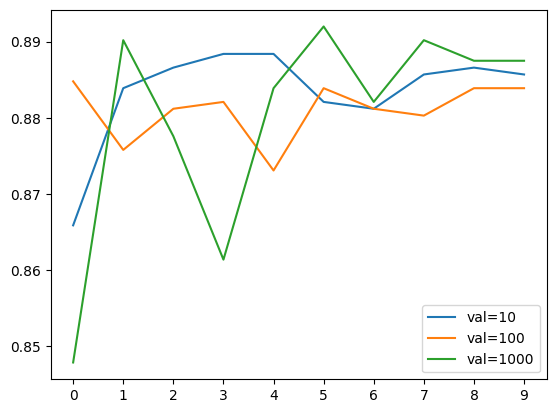

In [50]:
for size, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % size))

plt.xticks(np.arange(10))
#plt.yticks([0.78, 0.80, 0.82, 0.825, 0.83])
plt.legend()

Choose 10 for the size

### Regularization and Dropout

* Regularizing by freezing a part of the network
* Adding dropout to our model
* Experimenting with different values

In [51]:
def make_model(learning_rate=0.01, size_inner=100, droprate=0.5):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    
    outputs = keras.layers.Dense(6)(drop)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [52]:
learning_rate = 0.001
size = 10

scores = {}

for droprate in [0.0, 0.2, 0.5, 0.8]:
    print(droprate)

    model = make_model(
        learning_rate=learning_rate,
        size_inner=size,
        droprate=droprate
    )

    history = model.fit(train_ds, epochs=30, validation_data=val_ds)
    scores[droprate] = history.history

    print()
    print()



0.0
Epoch 1/30
139/139 [==============================] - 80s 561ms/step - loss: 0.6973 - accuracy: 0.7745 - val_loss: 0.3956 - val_accuracy: 0.8677
Epoch 2/30
139/139 [==============================] - 78s 560ms/step - loss: 0.3306 - accuracy: 0.8878 - val_loss: 0.3355 - val_accuracy: 0.8857
Epoch 3/30
139/139 [==============================] - 78s 562ms/step - loss: 0.2601 - accuracy: 0.9087 - val_loss: 0.3158 - val_accuracy: 0.8857
Epoch 4/30
139/139 [==============================] - 79s 567ms/step - loss: 0.2117 - accuracy: 0.9292 - val_loss: 0.3133 - val_accuracy: 0.8857
Epoch 5/30
139/139 [==============================] - 79s 566ms/step - loss: 0.1810 - accuracy: 0.9388 - val_loss: 0.3070 - val_accuracy: 0.8839
Epoch 6/30
139/139 [==============================] - 78s 562ms/step - loss: 0.1524 - accuracy: 0.9523 - val_loss: 0.3134 - val_accuracy: 0.8857
Epoch 7/30
139/139 [==============================] - 78s 560ms/step - loss: 0.1344 - accuracy: 0.9589 - val_loss: 0.3179 - va

139/139 [==============================] - 79s 565ms/step - loss: 1.4880 - accuracy: 0.3357 - val_loss: 1.1009 - val_accuracy: 0.5752
Epoch 24/30
139/139 [==============================] - 79s 565ms/step - loss: 1.4800 - accuracy: 0.3413 - val_loss: 1.1184 - val_accuracy: 0.5779
Epoch 25/30
139/139 [==============================] - 78s 563ms/step - loss: 1.4862 - accuracy: 0.3368 - val_loss: 1.1038 - val_accuracy: 0.5770
Epoch 26/30
139/139 [==============================] - 79s 565ms/step - loss: 1.4856 - accuracy: 0.3314 - val_loss: 1.0960 - val_accuracy: 0.5806
Epoch 27/30
139/139 [==============================] - 78s 564ms/step - loss: 1.4729 - accuracy: 0.3375 - val_loss: 1.1053 - val_accuracy: 0.5752
Epoch 28/30
139/139 [==============================] - 79s 566ms/step - loss: 1.4893 - accuracy: 0.3314 - val_loss: 1.1040 - val_accuracy: 0.5752
Epoch 29/30
139/139 [==============================] - 78s 564ms/step - loss: 1.4704 - accuracy: 0.3395 - val_loss: 1.1046 - val_accurac

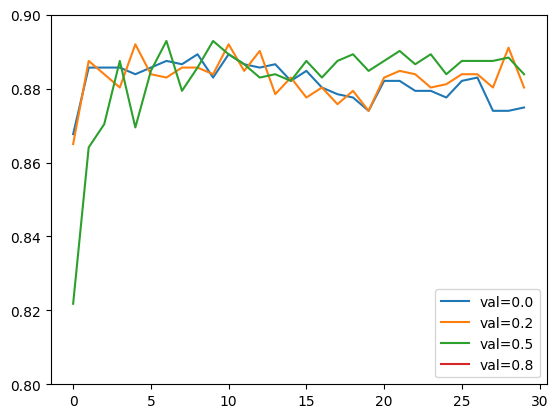

In [54]:
for droprate, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % droprate))

plt.ylim(0.8, 0.9)
plt.legend()

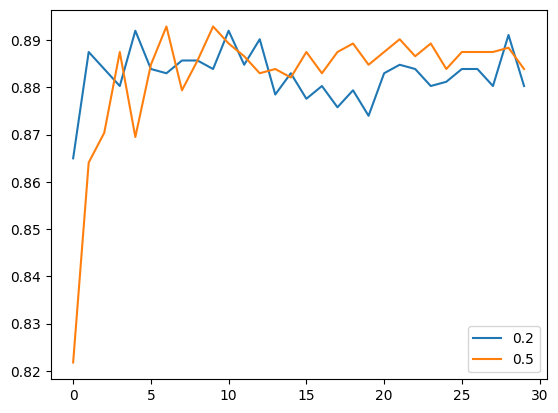

In [55]:
hist = scores[0.2]
plt.plot(hist['val_accuracy'], label=0.2)

hist = scores[0.5]
plt.plot(hist['val_accuracy'], label=0.5)

plt.legend()
#plt.plot(hist['accuracy'], label=('val=%s' % droprate))

Choose droprate = 0.2

### Data Augmentation

In [56]:
dirs

{'dataset_dir': './dataset',
 'raw_img_dir': './dataset/images',
 'sorted_img_dir': './dataset/sorted_images',
 'sorted_img_train': './dataset/sorted_images_train',
 'sorted_img_val': './dataset/sorted_images_val',
 'img_dir_test': './dataset/sorted_test'}

In [58]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=10.0,
    height_shift_range=10.0,
    shear_range=10.0,
    zoom_range=0.1,
    vertical_flip=True,
    horizontal_flip=True,
)

train_ds = train_gen.flow_from_directory(
    dirs['sorted_img_train'],
    target_size=(150, 150),
    batch_size=32
)

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = val_gen.flow_from_directory(
    dirs['sorted_img_val'],
    target_size=(150, 150),
    batch_size=32,
    shuffle=False
)

Found 4448 images belonging to 6 classes.
Found 1111 images belonging to 6 classes.


In [59]:
learning_rate = 0.001
size = 10
droprate = 0.2

model = make_model(
    learning_rate=learning_rate,
    size_inner=size,
    droprate=droprate
)

history = model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
139/139 [==============================] - 87s 606ms/step - loss: 0.9869 - accuracy: 0.6425 - val_loss: 0.5010 - val_accuracy: 0.8227
Epoch 2/50
139/139 [==============================] - 82s 589ms/step - loss: 0.6803 - accuracy: 0.7563 - val_loss: 0.3799 - val_accuracy: 0.8713
Epoch 3/50
139/139 [==============================] - 81s 580ms/step - loss: 0.6016 - accuracy: 0.7833 - val_loss: 0.3497 - val_accuracy: 0.8821
Epoch 4/50
139/139 [==============================] - 80s 572ms/step - loss: 0.5592 - accuracy: 0.7938 - val_loss: 0.3691 - val_accuracy: 0.8785
Epoch 5/50
139/139 [==============================] - 80s 577ms/step - loss: 0.5318 - accuracy: 0.8026 - val_loss: 0.3253 - val_accuracy: 0.8875
Epoch 6/50
139/139 [==============================] - 80s 573ms/step - loss: 0.5027 - accuracy: 0.8089 - val_loss: 0.3437 - val_accuracy: 0.8839
Epoch 7/50
139/139 [==============================] - 80s 574ms/step - loss: 0.4941 - accuracy: 0.8123 - val_loss: 0.3155 - val_ac

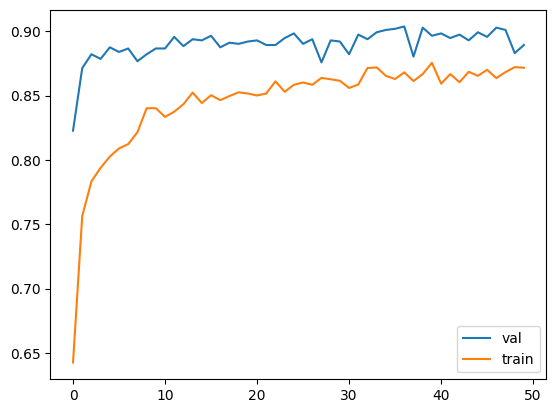

In [62]:
hist = history.history
plt.plot(hist['val_accuracy'], label='val')
plt.plot(hist['accuracy'], label='train')

plt.legend()


### Training a Larger Model

* Train a 299x299 model

In [60]:
def make_model(input_size=150, learning_rate=0.01, size_inner=100,
               droprate=0.5):

    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(input_size, input_size, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(input_size, input_size, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    
    outputs = keras.layers.Dense(6)(drop)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [61]:
input_size = 299

In [63]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=10.0,
    height_shift_range=10.0,
    shear_range=10.0,
    zoom_range=0.1,
    vertical_flip=True,
    horizontal_flip=True,
)


train_ds = train_gen.flow_from_directory(
    dirs['sorted_img_train'],
    target_size=(input_size, input_size),
    batch_size=32
)


val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = train_gen.flow_from_directory(
    dirs['sorted_img_val'],
    target_size=(input_size, input_size),
    batch_size=32,
    shuffle=False
)

Found 4448 images belonging to 6 classes.
Found 1111 images belonging to 6 classes.


In [64]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v2_1_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [65]:
# Using the best parameters we got previously
learning_rate = 0.001
size = 10
droprate = 0.2

model = make_model(
    input_size=input_size,
    learning_rate=learning_rate,
    size_inner=size,
    droprate=droprate
)

history = model.fit(train_ds, epochs=50, validation_data=val_ds,
                   callbacks=[checkpoint])

Epoch 1/50
139/139 [==============================] - 347s 2s/step - loss: 0.8942 - accuracy: 0.6574 - val_loss: 0.4187 - val_accuracy: 0.9064
Epoch 2/50
139/139 [==============================] - 344s 2s/step - loss: 0.5747 - accuracy: 0.7662 - val_loss: 0.2835 - val_accuracy: 0.9244
Epoch 3/50
139/139 [==============================] - 346s 2s/step - loss: 0.4670 - accuracy: 0.8235 - val_loss: 0.2457 - val_accuracy: 0.9226
Epoch 4/50
139/139 [==============================] - 345s 2s/step - loss: 0.4430 - accuracy: 0.8357 - val_loss: 0.2365 - val_accuracy: 0.9235
Epoch 5/50
139/139 [==============================] - 344s 2s/step - loss: 0.3942 - accuracy: 0.8566 - val_loss: 0.2083 - val_accuracy: 0.9316
Epoch 6/50
139/139 [==============================] - 345s 2s/step - loss: 0.3819 - accuracy: 0.8568 - val_loss: 0.2056 - val_accuracy: 0.9361
Epoch 7/50
139/139 [==============================] - 341s 2s/step - loss: 0.3702 - accuracy: 0.8588 - val_loss: 0.2085 - val_accuracy: 0.9271

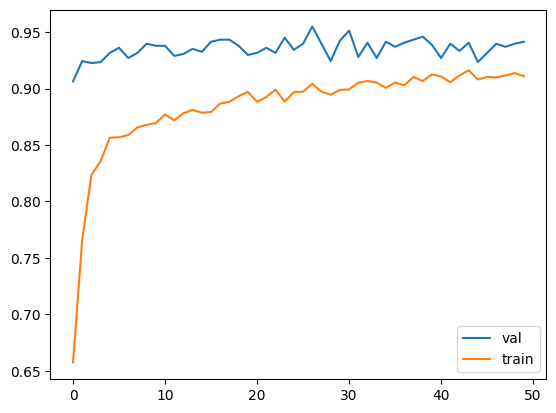

In [66]:
hist = history.history
plt.plot(hist['val_accuracy'], label='val')
plt.plot(hist['accuracy'], label='train')

plt.legend()

*Based on the result, we can see that training a larger model gave us better accuracy. However, keep in mind that using a larget model makes the training significantly larger*

## Testing the model

### Test on 1 image

In [65]:
# xception_v2_1_27_0.955.h5 gave us the best accuracy which is 95.5%
model = keras.models.load_model('xception_v2_1_27_0.955.h5')

In [54]:
label_map = {'cup': 0, 'fork': 1, 'glass': 2, 'knife': 3, 'plate': 4, 'spoon': 5}

In [8]:
image_size = (299,299)

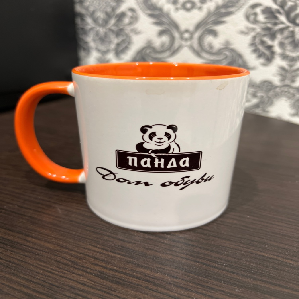

In [56]:
path = './dataset/sorted_test/0000.jpg'
img = load_img(path, target_size=(image_size))
img

* Pre-process the image

In [57]:
x = np.array(img)
X = np.array([x])
X = preprocess_input(X)

* Get the prediction

In [59]:
pred = model.predict(X)
pred_classes = pred.argmax(axis=-1)

print(pred[0])
print(pred_classes)

1/1 [==============================] - 0s 96ms/step
[ 8.296452  -6.3472857  1.3963548 -9.387292  -2.5154457 -5.7856536]
[0]


### Test on the whole test images

Now let's apply it to the entire testing dataset

- first, we'll create a generator
- then use the `evaluate` function to get accuracy 

In [11]:
dirs

{'dataset_dir': './dataset',
 'raw_img_dir': './dataset/images',
 'sorted_img_dir': './dataset/sorted_images',
 'sorted_img_train': './dataset/sorted_images_train',
 'sorted_img_val': './dataset/sorted_images_val',
 'img_dir_test': './dataset/sorted_test'}

In [18]:
import glob

In [21]:
test_dir = dirs['img_dir_test']

img_files = glob.glob(os.path.join(test_dir,'*.jpg'))

In [22]:
img_files

['./dataset/sorted_test/1834.jpg',
 './dataset/sorted_test/1454.jpg',
 './dataset/sorted_test/7560.jpg',
 './dataset/sorted_test/2429.jpg',
 './dataset/sorted_test/6620.jpg',
 './dataset/sorted_test/3378.jpg',
 './dataset/sorted_test/8198.jpg',
 './dataset/sorted_test/0901.jpg',
 './dataset/sorted_test/2159.jpg',
 './dataset/sorted_test/0274.jpg',
 './dataset/sorted_test/7846.jpg',
 './dataset/sorted_test/6021.jpg',
 './dataset/sorted_test/8487.jpg',
 './dataset/sorted_test/1439.jpg',
 './dataset/sorted_test/6643.jpg',
 './dataset/sorted_test/6719.jpg',
 './dataset/sorted_test/2082.jpg',
 './dataset/sorted_test/0136.jpg',
 './dataset/sorted_test/3357.jpg',
 './dataset/sorted_test/4862.jpg',
 './dataset/sorted_test/6099.jpg',
 './dataset/sorted_test/2033.jpg',
 './dataset/sorted_test/1641.jpg',
 './dataset/sorted_test/3529.jpg',
 './dataset/sorted_test/8658.jpg',
 './dataset/sorted_test/3390.jpg',
 './dataset/sorted_test/7039.jpg',
 './dataset/sorted_test/7791.jpg',
 './dataset/sorted_t

In [60]:
def test_predict(path_to_img, image_size = (299,299)):
    
    img = load_img(path_to_img, target_size=(image_size))
    
    x = np.array(img)
    X = np.array([x])
    X = preprocess_input(X)
    
    pred = model.predict(X)
    pred_class = pred.argmax(axis=-1)
    
    return pred_class, pred[0],

In [61]:
label_map

{'cup': 0, 'fork': 1, 'glass': 2, 'knife': 3, 'plate': 4, 'spoon': 5}

In [62]:
image_list = []
pred_class_list = []
pred_proba_list = []

for file in img_files:
    pred_class ,pred_proba = test_predict(file, image_size)
    
    image_list.append(os.path.basename(file))
    pred_class_list.append(pred_class)
    pred_proba_list.append(pred_proba)
    
    print(f'{file} was successfully predicted')
    print()
    

1/1 [==============================] - 0s 95ms/step
./dataset/sorted_test/1834.jpg was successfully predicted

1/1 [==============================] - 0s 80ms/step
./dataset/sorted_test/1454.jpg was successfully predicted

1/1 [==============================] - 0s 86ms/step
./dataset/sorted_test/7560.jpg was successfully predicted

1/1 [==============================] - 0s 82ms/step
./dataset/sorted_test/2429.jpg was successfully predicted

1/1 [==============================] - 0s 81ms/step
./dataset/sorted_test/6620.jpg was successfully predicted

1/1 [==============================] - 0s 79ms/step
./dataset/sorted_test/3378.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/8198.jpg was successfully predicted

1/1 [==============================] - 0s 82ms/step
./dataset/sorted_test/0901.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/2159.jpg was successfully predicted

1

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/2355.jpg was successfully predicted

1/1 [==============================] - 0s 82ms/step
./dataset/sorted_test/1170.jpg was successfully predicted

1/1 [==============================] - 0s 82ms/step
./dataset/sorted_test/4804.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/0087.jpg was successfully predicted

1/1 [==============================] - 0s 81ms/step
./dataset/sorted_test/7492.jpg was successfully predicted

1/1 [==============================] - 0s 79ms/step
./dataset/sorted_test/7283.jpg was successfully predicted

1/1 [==============================] - 0s 81ms/step
./dataset/sorted_test/2661.jpg was successfully predicted

1/1 [==============================] - 0s 81ms/step
./dataset/sorted_test/7360.jpg was successfully predicted

1/1 [==============================] - 0s 81ms/step
./dataset/sorted_test/3598.jpg was successfully predicted

1

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/3091.jpg was successfully predicted

1/1 [==============================] - 0s 82ms/step
./dataset/sorted_test/8251.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/3573.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/2319.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/0900.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/1101.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/5981.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/1485.jpg was successfully predicted

1/1 [==============================] - 0s 89ms/step
./dataset/sorted_test/6853.jpg was successfully predicted

1

1/1 [==============================] - 0s 87ms/step
./dataset/sorted_test/0238.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/6225.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/7236.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/2016.jpg was successfully predicted

1/1 [==============================] - 0s 89ms/step
./dataset/sorted_test/4444.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/1159.jpg was successfully predicted

1/1 [==============================] - 0s 87ms/step
./dataset/sorted_test/0594.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/8312.jpg was successfully predicted

1/1 [==============================] - 0s 86ms/step
./dataset/sorted_test/6427.jpg was successfully predicted

1

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/1409.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/1892.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/8022.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/6251.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/1718.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/3567.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/8387.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/1823.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/6340.jpg was successfully predicted

1

1/1 [==============================] - 0s 90ms/step
./dataset/sorted_test/2579.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/2332.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/8142.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/7261.jpg was successfully predicted

1/1 [==============================] - 0s 82ms/step
./dataset/sorted_test/8253.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/5745.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/6892.jpg was successfully predicted

1/1 [==============================] - 0s 81ms/step
./dataset/sorted_test/1360.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/3701.jpg was successfully predicted

1

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/4624.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/0249.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/6869.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/9378.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/2364.jpg was successfully predicted

1/1 [==============================] - 0s 81ms/step
./dataset/sorted_test/3875.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/2073.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/0072.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/2714.jpg was successfully predicted

1

1/1 [==============================] - 0s 82ms/step
./dataset/sorted_test/1034.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/1542.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/6295.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/5617.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/2310.jpg was successfully predicted

1/1 [==============================] - 0s 90ms/step
./dataset/sorted_test/4125.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/7712.jpg was successfully predicted

1/1 [==============================] - 0s 82ms/step
./dataset/sorted_test/2574.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/0018.jpg was successfully predicted

1

1/1 [==============================] - 0s 82ms/step
./dataset/sorted_test/3180.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/3284.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/5418.jpg was successfully predicted

1/1 [==============================] - 0s 87ms/step
./dataset/sorted_test/5943.jpg was successfully predicted

1/1 [==============================] - 0s 82ms/step
./dataset/sorted_test/8565.jpg was successfully predicted

1/1 [==============================] - 0s 78ms/step
./dataset/sorted_test/7132.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/7682.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/1613.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/5955.jpg was successfully predicted

1

1/1 [==============================] - 0s 92ms/step
./dataset/sorted_test/8125.jpg was successfully predicted

1/1 [==============================] - 0s 93ms/step
./dataset/sorted_test/3915.jpg was successfully predicted

1/1 [==============================] - 0s 90ms/step
./dataset/sorted_test/9367.jpg was successfully predicted

1/1 [==============================] - 0s 88ms/step
./dataset/sorted_test/7655.jpg was successfully predicted

1/1 [==============================] - 0s 88ms/step
./dataset/sorted_test/5604.jpg was successfully predicted

1/1 [==============================] - 0s 89ms/step
./dataset/sorted_test/3123.jpg was successfully predicted

1/1 [==============================] - 0s 87ms/step
./dataset/sorted_test/4273.jpg was successfully predicted

1/1 [==============================] - 0s 92ms/step
./dataset/sorted_test/3131.jpg was successfully predicted

1/1 [==============================] - 0s 95ms/step
./dataset/sorted_test/1161.jpg was successfully predicted

1

1/1 [==============================] - 0s 88ms/step
./dataset/sorted_test/3468.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/7280.jpg was successfully predicted

1/1 [==============================] - 0s 86ms/step
./dataset/sorted_test/8100.jpg was successfully predicted

1/1 [==============================] - 0s 86ms/step
./dataset/sorted_test/8806.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/3352.jpg was successfully predicted

1/1 [==============================] - 0s 104ms/step
./dataset/sorted_test/9116.jpg was successfully predicted

1/1 [==============================] - 0s 86ms/step
./dataset/sorted_test/3942.jpg was successfully predicted

1/1 [==============================] - 0s 86ms/step
./dataset/sorted_test/0749.jpg was successfully predicted

1/1 [==============================] - 0s 104ms/step
./dataset/sorted_test/6987.jpg was successfully predicted


1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/2815.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/8171.jpg was successfully predicted

1/1 [==============================] - 0s 86ms/step
./dataset/sorted_test/3960.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/4456.jpg was successfully predicted

1/1 [==============================] - 0s 89ms/step
./dataset/sorted_test/6913.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/6679.jpg was successfully predicted

1/1 [==============================] - 0s 86ms/step
./dataset/sorted_test/8368.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/8547.jpg was successfully predicted

1/1 [==============================] - 0s 88ms/step
./dataset/sorted_test/3597.jpg was successfully predicted

1

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/6602.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/5694.jpg was successfully predicted

1/1 [==============================] - 0s 87ms/step
./dataset/sorted_test/6901.jpg was successfully predicted

1/1 [==============================] - 0s 86ms/step
./dataset/sorted_test/8105.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/4073.jpg was successfully predicted

1/1 [==============================] - 0s 82ms/step
./dataset/sorted_test/8461.jpg was successfully predicted

1/1 [==============================] - 0s 82ms/step
./dataset/sorted_test/0229.jpg was successfully predicted

1/1 [==============================] - 0s 82ms/step
./dataset/sorted_test/5562.jpg was successfully predicted

1/1 [==============================] - 0s 82ms/step
./dataset/sorted_test/7274.jpg was successfully predicted

1

1/1 [==============================] - 0s 86ms/step
./dataset/sorted_test/2290.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/0291.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/8975.jpg was successfully predicted

1/1 [==============================] - 0s 81ms/step
./dataset/sorted_test/4537.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/8439.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/5088.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/4297.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/9018.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/3575.jpg was successfully predicted

1

1/1 [==============================] - 0s 86ms/step
./dataset/sorted_test/4388.jpg was successfully predicted

1/1 [==============================] - 0s 82ms/step
./dataset/sorted_test/2888.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/6344.jpg was successfully predicted

1/1 [==============================] - 0s 82ms/step
./dataset/sorted_test/3335.jpg was successfully predicted

1/1 [==============================] - 0s 87ms/step
./dataset/sorted_test/9266.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/9350.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/1493.jpg was successfully predicted

1/1 [==============================] - 0s 88ms/step
./dataset/sorted_test/0427.jpg was successfully predicted

1/1 [==============================] - 0s 82ms/step
./dataset/sorted_test/6509.jpg was successfully predicted

1

1/1 [==============================] - 0s 80ms/step
./dataset/sorted_test/5788.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/4636.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/6504.jpg was successfully predicted

1/1 [==============================] - 0s 81ms/step
./dataset/sorted_test/7282.jpg was successfully predicted

1/1 [==============================] - 0s 82ms/step
./dataset/sorted_test/6276.jpg was successfully predicted

1/1 [==============================] - 0s 88ms/step
./dataset/sorted_test/1999.jpg was successfully predicted

1/1 [==============================] - 0s 87ms/step
./dataset/sorted_test/1421.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/8575.jpg was successfully predicted

1/1 [==============================] - 0s 82ms/step
./dataset/sorted_test/3253.jpg was successfully predicted

1

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/8260.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/7370.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/7504.jpg was successfully predicted

1/1 [==============================] - 0s 87ms/step
./dataset/sorted_test/9069.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/1241.jpg was successfully predicted

1/1 [==============================] - 0s 87ms/step
./dataset/sorted_test/2750.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/1917.jpg was successfully predicted

1/1 [==============================] - 0s 89ms/step
./dataset/sorted_test/7855.jpg was successfully predicted

1/1 [==============================] - 0s 98ms/step
./dataset/sorted_test/4667.jpg was successfully predicted

1

1/1 [==============================] - 0s 86ms/step
./dataset/sorted_test/2788.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/4070.jpg was successfully predicted

1/1 [==============================] - 0s 86ms/step
./dataset/sorted_test/4672.jpg was successfully predicted

1/1 [==============================] - 0s 81ms/step
./dataset/sorted_test/5126.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/2628.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/9204.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/9021.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/6944.jpg was successfully predicted

1/1 [==============================] - 0s 81ms/step
./dataset/sorted_test/8137.jpg was successfully predicted

1

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/3706.jpg was successfully predicted

1/1 [==============================] - 0s 86ms/step
./dataset/sorted_test/0372.jpg was successfully predicted

1/1 [==============================] - 0s 82ms/step
./dataset/sorted_test/5173.jpg was successfully predicted

1/1 [==============================] - 0s 82ms/step
./dataset/sorted_test/2731.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/4098.jpg was successfully predicted

1/1 [==============================] - 0s 87ms/step
./dataset/sorted_test/8586.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/9334.jpg was successfully predicted

1/1 [==============================] - 0s 86ms/step
./dataset/sorted_test/2375.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/3983.jpg was successfully predicted

1

1/1 [==============================] - 0s 79ms/step
./dataset/sorted_test/9227.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/7264.jpg was successfully predicted

1/1 [==============================] - 0s 93ms/step
./dataset/sorted_test/6653.jpg was successfully predicted

1/1 [==============================] - 0s 86ms/step
./dataset/sorted_test/4033.jpg was successfully predicted

1/1 [==============================] - 0s 88ms/step
./dataset/sorted_test/8759.jpg was successfully predicted

1/1 [==============================] - 0s 82ms/step
./dataset/sorted_test/2042.jpg was successfully predicted

1/1 [==============================] - 0s 87ms/step
./dataset/sorted_test/6030.jpg was successfully predicted

1/1 [==============================] - 0s 82ms/step
./dataset/sorted_test/5328.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/0539.jpg was successfully predicted

1

1/1 [==============================] - 0s 95ms/step
./dataset/sorted_test/0002.jpg was successfully predicted

1/1 [==============================] - 0s 81ms/step
./dataset/sorted_test/4705.jpg was successfully predicted

1/1 [==============================] - 0s 86ms/step
./dataset/sorted_test/1224.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/7270.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/8873.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/1651.jpg was successfully predicted

1/1 [==============================] - 0s 86ms/step
./dataset/sorted_test/5512.jpg was successfully predicted

1/1 [==============================] - 0s 86ms/step
./dataset/sorted_test/1474.jpg was successfully predicted

1/1 [==============================] - 0s 87ms/step
./dataset/sorted_test/5335.jpg was successfully predicted

1

1/1 [==============================] - 0s 82ms/step
./dataset/sorted_test/8627.jpg was successfully predicted

1/1 [==============================] - 0s 88ms/step
./dataset/sorted_test/1276.jpg was successfully predicted

1/1 [==============================] - 0s 90ms/step
./dataset/sorted_test/2258.jpg was successfully predicted

1/1 [==============================] - 0s 81ms/step
./dataset/sorted_test/8084.jpg was successfully predicted

1/1 [==============================] - 0s 81ms/step
./dataset/sorted_test/2397.jpg was successfully predicted

1/1 [==============================] - 0s 81ms/step
./dataset/sorted_test/8036.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/3209.jpg was successfully predicted

1/1 [==============================] - 0s 80ms/step
./dataset/sorted_test/7005.jpg was successfully predicted

1/1 [==============================] - 0s 87ms/step
./dataset/sorted_test/1377.jpg was successfully predicted

1

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/6822.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/4440.jpg was successfully predicted

1/1 [==============================] - 0s 88ms/step
./dataset/sorted_test/8709.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/4201.jpg was successfully predicted

1/1 [==============================] - 0s 86ms/step
./dataset/sorted_test/3853.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/5742.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/0312.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/7122.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/4750.jpg was successfully predicted

1

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/5743.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/2853.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/3822.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/8842.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/2421.jpg was successfully predicted

1/1 [==============================] - 0s 86ms/step
./dataset/sorted_test/7399.jpg was successfully predicted

1/1 [==============================] - 0s 86ms/step
./dataset/sorted_test/2827.jpg was successfully predicted

1/1 [==============================] - 0s 90ms/step
./dataset/sorted_test/3998.jpg was successfully predicted

1/1 [==============================] - 0s 86ms/step
./dataset/sorted_test/9422.jpg was successfully predicted

1

1/1 [==============================] - 0s 87ms/step
./dataset/sorted_test/4932.jpg was successfully predicted

1/1 [==============================] - 0s 86ms/step
./dataset/sorted_test/0410.jpg was successfully predicted

1/1 [==============================] - 0s 89ms/step
./dataset/sorted_test/1129.jpg was successfully predicted

1/1 [==============================] - 0s 88ms/step
./dataset/sorted_test/5031.jpg was successfully predicted

1/1 [==============================] - 0s 90ms/step
./dataset/sorted_test/2977.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/0615.jpg was successfully predicted

1/1 [==============================] - 0s 88ms/step
./dataset/sorted_test/2408.jpg was successfully predicted

1/1 [==============================] - 0s 92ms/step
./dataset/sorted_test/6747.jpg was successfully predicted

1/1 [==============================] - 0s 88ms/step
./dataset/sorted_test/0430.jpg was successfully predicted

1

1/1 [==============================] - 0s 86ms/step
./dataset/sorted_test/0307.jpg was successfully predicted

1/1 [==============================] - 0s 92ms/step
./dataset/sorted_test/5033.jpg was successfully predicted

1/1 [==============================] - 0s 88ms/step
./dataset/sorted_test/4494.jpg was successfully predicted

1/1 [==============================] - 0s 87ms/step
./dataset/sorted_test/7884.jpg was successfully predicted

1/1 [==============================] - 0s 86ms/step
./dataset/sorted_test/3313.jpg was successfully predicted

1/1 [==============================] - 0s 86ms/step
./dataset/sorted_test/2862.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/0110.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/0361.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/7062.jpg was successfully predicted

1

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/3145.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/7619.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/6677.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/6799.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/4915.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/0542.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/8086.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/2383.jpg was successfully predicted

1/1 [==============================] - 0s 87ms/step
./dataset/sorted_test/4831.jpg was successfully predicted

1

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/5837.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/0575.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/0365.jpg was successfully predicted

1/1 [==============================] - 0s 81ms/step
./dataset/sorted_test/1729.jpg was successfully predicted

1/1 [==============================] - 0s 81ms/step
./dataset/sorted_test/7417.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/7138.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/4232.jpg was successfully predicted

1/1 [==============================] - 0s 82ms/step
./dataset/sorted_test/6456.jpg was successfully predicted

1/1 [==============================] - 0s 82ms/step
./dataset/sorted_test/3828.jpg was successfully predicted

1

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/5703.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/0127.jpg was successfully predicted

1/1 [==============================] - 0s 82ms/step
./dataset/sorted_test/8377.jpg was successfully predicted

1/1 [==============================] - 0s 82ms/step
./dataset/sorted_test/2762.jpg was successfully predicted

1/1 [==============================] - 0s 87ms/step
./dataset/sorted_test/1431.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/7263.jpg was successfully predicted

1/1 [==============================] - 0s 82ms/step
./dataset/sorted_test/4293.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/0121.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/1702.jpg was successfully predicted

1

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/1346.jpg was successfully predicted

1/1 [==============================] - 0s 81ms/step
./dataset/sorted_test/8165.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/1775.jpg was successfully predicted

1/1 [==============================] - 0s 82ms/step
./dataset/sorted_test/7275.jpg was successfully predicted

1/1 [==============================] - 0s 87ms/step
./dataset/sorted_test/2022.jpg was successfully predicted

1/1 [==============================] - 0s 81ms/step
./dataset/sorted_test/5414.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/4131.jpg was successfully predicted

1/1 [==============================] - 0s 82ms/step
./dataset/sorted_test/1593.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/3823.jpg was successfully predicted

1

1/1 [==============================] - 0s 80ms/step
./dataset/sorted_test/2889.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/3279.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/9027.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/4359.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/0436.jpg was successfully predicted

1/1 [==============================] - 0s 81ms/step
./dataset/sorted_test/7091.jpg was successfully predicted

1/1 [==============================] - 0s 87ms/step
./dataset/sorted_test/0788.jpg was successfully predicted

1/1 [==============================] - 0s 82ms/step
./dataset/sorted_test/1074.jpg was successfully predicted

1/1 [==============================] - 0s 82ms/step
./dataset/sorted_test/7012.jpg was successfully predicted

1

1/1 [==============================] - 0s 81ms/step
./dataset/sorted_test/1846.jpg was successfully predicted

1/1 [==============================] - 0s 81ms/step
./dataset/sorted_test/4977.jpg was successfully predicted

1/1 [==============================] - 0s 86ms/step
./dataset/sorted_test/6299.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/5389.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/8078.jpg was successfully predicted

1/1 [==============================] - 0s 81ms/step
./dataset/sorted_test/0913.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/5266.jpg was successfully predicted

1/1 [==============================] - 0s 87ms/step
./dataset/sorted_test/7567.jpg was successfully predicted

1/1 [==============================] - 0s 82ms/step
./dataset/sorted_test/5780.jpg was successfully predicted

1

1/1 [==============================] - 0s 86ms/step
./dataset/sorted_test/0469.jpg was successfully predicted

1/1 [==============================] - 0s 82ms/step
./dataset/sorted_test/4767.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/5997.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/2143.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/8853.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/8091.jpg was successfully predicted

1/1 [==============================] - 0s 89ms/step
./dataset/sorted_test/2323.jpg was successfully predicted

1/1 [==============================] - 0s 81ms/step
./dataset/sorted_test/3440.jpg was successfully predicted

1/1 [==============================] - 0s 80ms/step
./dataset/sorted_test/5594.jpg was successfully predicted

1

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/4041.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/4981.jpg was successfully predicted

1/1 [==============================] - 0s 81ms/step
./dataset/sorted_test/2496.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/2732.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/8424.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/1570.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/9172.jpg was successfully predicted

1/1 [==============================] - 0s 80ms/step
./dataset/sorted_test/2557.jpg was successfully predicted

1/1 [==============================] - 0s 79ms/step
./dataset/sorted_test/3750.jpg was successfully predicted

1

1/1 [==============================] - 0s 87ms/step
./dataset/sorted_test/3147.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/6933.jpg was successfully predicted

1/1 [==============================] - 0s 86ms/step
./dataset/sorted_test/6149.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/9426.jpg was successfully predicted

1/1 [==============================] - 0s 87ms/step
./dataset/sorted_test/5707.jpg was successfully predicted

1/1 [==============================] - 0s 78ms/step
./dataset/sorted_test/7172.jpg was successfully predicted

1/1 [==============================] - 0s 81ms/step
./dataset/sorted_test/6715.jpg was successfully predicted

1/1 [==============================] - 0s 80ms/step
./dataset/sorted_test/0261.jpg was successfully predicted

1/1 [==============================] - 0s 81ms/step
./dataset/sorted_test/7204.jpg was successfully predicted

1

1/1 [==============================] - 0s 86ms/step
./dataset/sorted_test/3851.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/2777.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/6320.jpg was successfully predicted

1/1 [==============================] - 0s 80ms/step
./dataset/sorted_test/4093.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/6091.jpg was successfully predicted

1/1 [==============================] - 0s 88ms/step
./dataset/sorted_test/2038.jpg was successfully predicted

1/1 [==============================] - 0s 81ms/step
./dataset/sorted_test/1768.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/5288.jpg was successfully predicted

1/1 [==============================] - 0s 87ms/step
./dataset/sorted_test/9073.jpg was successfully predicted

1

1/1 [==============================] - 0s 82ms/step
./dataset/sorted_test/1725.jpg was successfully predicted

1/1 [==============================] - 0s 82ms/step
./dataset/sorted_test/8711.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/0706.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/1379.jpg was successfully predicted

1/1 [==============================] - 0s 82ms/step
./dataset/sorted_test/8587.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/6403.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/2784.jpg was successfully predicted

1/1 [==============================] - 0s 86ms/step
./dataset/sorted_test/6599.jpg was successfully predicted

1/1 [==============================] - 0s 81ms/step
./dataset/sorted_test/4264.jpg was successfully predicted

1

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/2510.jpg was successfully predicted

1/1 [==============================] - 0s 82ms/step
./dataset/sorted_test/6336.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/2281.jpg was successfully predicted

1/1 [==============================] - 0s 80ms/step
./dataset/sorted_test/7432.jpg was successfully predicted

1/1 [==============================] - 0s 86ms/step
./dataset/sorted_test/3736.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/0093.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/8332.jpg was successfully predicted

1/1 [==============================] - 0s 82ms/step
./dataset/sorted_test/8059.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/4417.jpg was successfully predicted

1

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/3744.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/4042.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/8797.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/2868.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/0722.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/5258.jpg was successfully predicted

1/1 [==============================] - 0s 86ms/step
./dataset/sorted_test/5710.jpg was successfully predicted

1/1 [==============================] - 0s 82ms/step
./dataset/sorted_test/5775.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/1763.jpg was successfully predicted

1

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/9386.jpg was successfully predicted

1/1 [==============================] - 0s 96ms/step
./dataset/sorted_test/0757.jpg was successfully predicted

1/1 [==============================] - 0s 92ms/step
./dataset/sorted_test/6574.jpg was successfully predicted

1/1 [==============================] - 0s 90ms/step
./dataset/sorted_test/1153.jpg was successfully predicted

1/1 [==============================] - 0s 88ms/step
./dataset/sorted_test/3283.jpg was successfully predicted

1/1 [==============================] - 0s 86ms/step
./dataset/sorted_test/6472.jpg was successfully predicted

1/1 [==============================] - 0s 90ms/step
./dataset/sorted_test/8421.jpg was successfully predicted

1/1 [==============================] - 0s 92ms/step
./dataset/sorted_test/4736.jpg was successfully predicted

1/1 [==============================] - 0s 87ms/step
./dataset/sorted_test/1197.jpg was successfully predicted

1

1/1 [==============================] - 0s 88ms/step
./dataset/sorted_test/5221.jpg was successfully predicted

1/1 [==============================] - 0s 88ms/step
./dataset/sorted_test/2299.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/5201.jpg was successfully predicted

1/1 [==============================] - 0s 86ms/step
./dataset/sorted_test/4548.jpg was successfully predicted

1/1 [==============================] - 0s 90ms/step
./dataset/sorted_test/2389.jpg was successfully predicted

1/1 [==============================] - 0s 90ms/step
./dataset/sorted_test/4822.jpg was successfully predicted

1/1 [==============================] - 0s 87ms/step
./dataset/sorted_test/0524.jpg was successfully predicted

1/1 [==============================] - 0s 89ms/step
./dataset/sorted_test/6536.jpg was successfully predicted

1/1 [==============================] - 0s 86ms/step
./dataset/sorted_test/3261.jpg was successfully predicted

1

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/2152.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/4470.jpg was successfully predicted

1/1 [==============================] - 0s 80ms/step
./dataset/sorted_test/8002.jpg was successfully predicted

1/1 [==============================] - 0s 87ms/step
./dataset/sorted_test/1714.jpg was successfully predicted

1/1 [==============================] - 0s 86ms/step
./dataset/sorted_test/7879.jpg was successfully predicted

1/1 [==============================] - 0s 86ms/step
./dataset/sorted_test/7498.jpg was successfully predicted

1/1 [==============================] - 0s 86ms/step
./dataset/sorted_test/5178.jpg was successfully predicted

1/1 [==============================] - 0s 88ms/step
./dataset/sorted_test/7313.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/9136.jpg was successfully predicted

1

1/1 [==============================] - 0s 82ms/step
./dataset/sorted_test/4203.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/4830.jpg was successfully predicted

1/1 [==============================] - 0s 88ms/step
./dataset/sorted_test/1097.jpg was successfully predicted

1/1 [==============================] - 0s 87ms/step
./dataset/sorted_test/3302.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/8609.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/3650.jpg was successfully predicted

1/1 [==============================] - 0s 86ms/step
./dataset/sorted_test/4317.jpg was successfully predicted

1/1 [==============================] - 0s 81ms/step
./dataset/sorted_test/5689.jpg was successfully predicted

1/1 [==============================] - 0s 86ms/step
./dataset/sorted_test/3161.jpg was successfully predicted

1

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/2544.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/6584.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/7197.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/6262.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/0693.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/6365.jpg was successfully predicted

1/1 [==============================] - 0s 81ms/step
./dataset/sorted_test/5334.jpg was successfully predicted

1/1 [==============================] - 0s 81ms/step
./dataset/sorted_test/0513.jpg was successfully predicted

1/1 [==============================] - 0s 82ms/step
./dataset/sorted_test/3820.jpg was successfully predicted

1

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/4789.jpg was successfully predicted

1/1 [==============================] - 0s 81ms/step
./dataset/sorted_test/7485.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/8972.jpg was successfully predicted

1/1 [==============================] - 0s 81ms/step
./dataset/sorted_test/0155.jpg was successfully predicted

1/1 [==============================] - 0s 86ms/step
./dataset/sorted_test/7603.jpg was successfully predicted

1/1 [==============================] - 0s 80ms/step
./dataset/sorted_test/0550.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/7451.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/5821.jpg was successfully predicted

1/1 [==============================] - 0s 80ms/step
./dataset/sorted_test/7233.jpg was successfully predicted

1

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/2233.jpg was successfully predicted

1/1 [==============================] - 0s 82ms/step
./dataset/sorted_test/3774.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/7833.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/1893.jpg was successfully predicted

1/1 [==============================] - 0s 81ms/step
./dataset/sorted_test/7053.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/7305.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/6540.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/8888.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/0389.jpg was successfully predicted

1

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/1652.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/7748.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/5832.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/7020.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/5768.jpg was successfully predicted

1/1 [==============================] - 0s 92ms/step
./dataset/sorted_test/6941.jpg was successfully predicted

1/1 [==============================] - 0s 93ms/step
./dataset/sorted_test/6315.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/9025.jpg was successfully predicted

1/1 [==============================] - 0s 79ms/step
./dataset/sorted_test/7176.jpg was successfully predicted

1

1/1 [==============================] - 0s 81ms/step
./dataset/sorted_test/3085.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/4001.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/0146.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/1295.jpg was successfully predicted

1/1 [==============================] - 0s 82ms/step
./dataset/sorted_test/1700.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/0219.jpg was successfully predicted

1/1 [==============================] - 0s 81ms/step
./dataset/sorted_test/8638.jpg was successfully predicted

1/1 [==============================] - 0s 82ms/step
./dataset/sorted_test/4577.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/6089.jpg was successfully predicted

1

1/1 [==============================] - 0s 86ms/step
./dataset/sorted_test/3541.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/6596.jpg was successfully predicted

1/1 [==============================] - 0s 81ms/step
./dataset/sorted_test/8259.jpg was successfully predicted

1/1 [==============================] - 0s 82ms/step
./dataset/sorted_test/5014.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/0388.jpg was successfully predicted

1/1 [==============================] - 0s 79ms/step
./dataset/sorted_test/0573.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/8130.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/2995.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/1160.jpg was successfully predicted

1

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/1289.jpg was successfully predicted

1/1 [==============================] - 0s 81ms/step
./dataset/sorted_test/6727.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/3168.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/2660.jpg was successfully predicted

1/1 [==============================] - 0s 82ms/step
./dataset/sorted_test/8835.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/6244.jpg was successfully predicted

1/1 [==============================] - 0s 87ms/step
./dataset/sorted_test/7513.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/4421.jpg was successfully predicted

1/1 [==============================] - 0s 86ms/step
./dataset/sorted_test/3899.jpg was successfully predicted

1

1/1 [==============================] - 0s 82ms/step
./dataset/sorted_test/2268.jpg was successfully predicted

1/1 [==============================] - 0s 81ms/step
./dataset/sorted_test/8228.jpg was successfully predicted

1/1 [==============================] - 0s 82ms/step
./dataset/sorted_test/2251.jpg was successfully predicted

1/1 [==============================] - 0s 87ms/step
./dataset/sorted_test/6356.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/0939.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/5540.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/1684.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/6468.jpg was successfully predicted

1/1 [==============================] - 0s 83ms/step
./dataset/sorted_test/0281.jpg was successfully predicted

1

1/1 [==============================] - 0s 87ms/step
./dataset/sorted_test/2284.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/3772.jpg was successfully predicted

1/1 [==============================] - 0s 88ms/step
./dataset/sorted_test/4148.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/0564.jpg was successfully predicted

1/1 [==============================] - 0s 86ms/step
./dataset/sorted_test/9301.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/2393.jpg was successfully predicted

1/1 [==============================] - 0s 84ms/step
./dataset/sorted_test/5310.jpg was successfully predicted

1/1 [==============================] - 0s 85ms/step
./dataset/sorted_test/5285.jpg was successfully predicted

1/1 [==============================] - 0s 82ms/step
./dataset/sorted_test/5949.jpg was successfully predicted

1

In [70]:
df_predict = pd.DataFrame(
    {
        'image': image_list,
        'class': [x[0] for x in pred_class_list],
        'pred_proba_list': pred_proba_list
    }
)

df_predict

,image,class,pred_proba_list
0,1834.jpg,5,"[-4.0600257, 4.504364, -1.6307756, -9.24904, -..."
1,1454.jpg,0,"[6.6628165, -9.0188875, 2.1514945, -8.638204, ..."
2,7560.jpg,3,"[-4.9584546, 3.0643847, -3.092083, 7.725851, -..."
3,2429.jpg,0,"[5.1667, -8.532581, 2.4527223, -7.782108, -0.9..."
4,6620.jpg,2,"[1.4270092, -10.286513, 4.851767, -7.8669343, ..."
...,...,...,...
3803,8859.jpg,2,"[3.409156, -11.529683, 3.9372435, -7.8331046, ..."
3804,3235.jpg,4,"[2.480999, -7.197036, 1.7394632, -7.9475846, 7..."
3805,3395.jpg,3,"[-4.6355805, 2.7734299, -2.4216175, 6.7293677,..."
3806,0845.jpg,0,"[9.377659, -8.361412, 1.9880742, -11.106598, -..."


In [76]:
label_lookup = {y: x for x,y in label_map.items()}

df_submission = pd.DataFrame(
    {
        'Id': [x[:-4] for x in image_list],
        'label': [label_lookup[x[0]] for x in pred_class_list],
    }
)

df_submission = df_submission.sort_values(by=['Id'])
df_submission

,Id,label
380,0000,cup
3545,0001,spoon
1480,0002,plate
3303,0007,plate
586,0008,cup
...,...,...
3132,9433,knife
1024,9436,plate
180,9439,spoon
2259,9442,glass


In [78]:
df_submission.to_csv('./dataset/submission_chan.csv', index = False)

## Saving the Model
To use the model for deployment, we will save it using tensorflow built-in `saved_model` function

In [39]:
import tensorflow as tf
from tensorflow import keras

model = keras.models.load_model('xception_v2_1_27_0.955.h5')

tf.saved_model.save(model, 'converted_model')

INFO:tensorflow:Assets written to: converted_model/assets


INFO:tensorflow:Assets written to: converted_model/assets
